# HW3

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 150
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
!pip install pyfolio
import pyfolio as pf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 907 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91 kB 2.5 MB/s 
     |████████████████████████████████| 52 kB 774 kB/s 
     |████████████████████████████████| 1.6 MB 55.3 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88681 sha256=ed9d13034d01587e24ce2c0ca6c76681ea3fb88afd8d2435d3a0b662406ae866
  Stored in directory: /root/.cache/pip/wheels/42/16/92/9c9d49efccc497040268960f0825101cc9b1c6e41cdc5a409e
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39778 sha256=688c9b227e5b45fc113332eb767f8d83021e40518bb41297d7b0df554f9b620

/usr/local/lib/python3.8/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252 
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


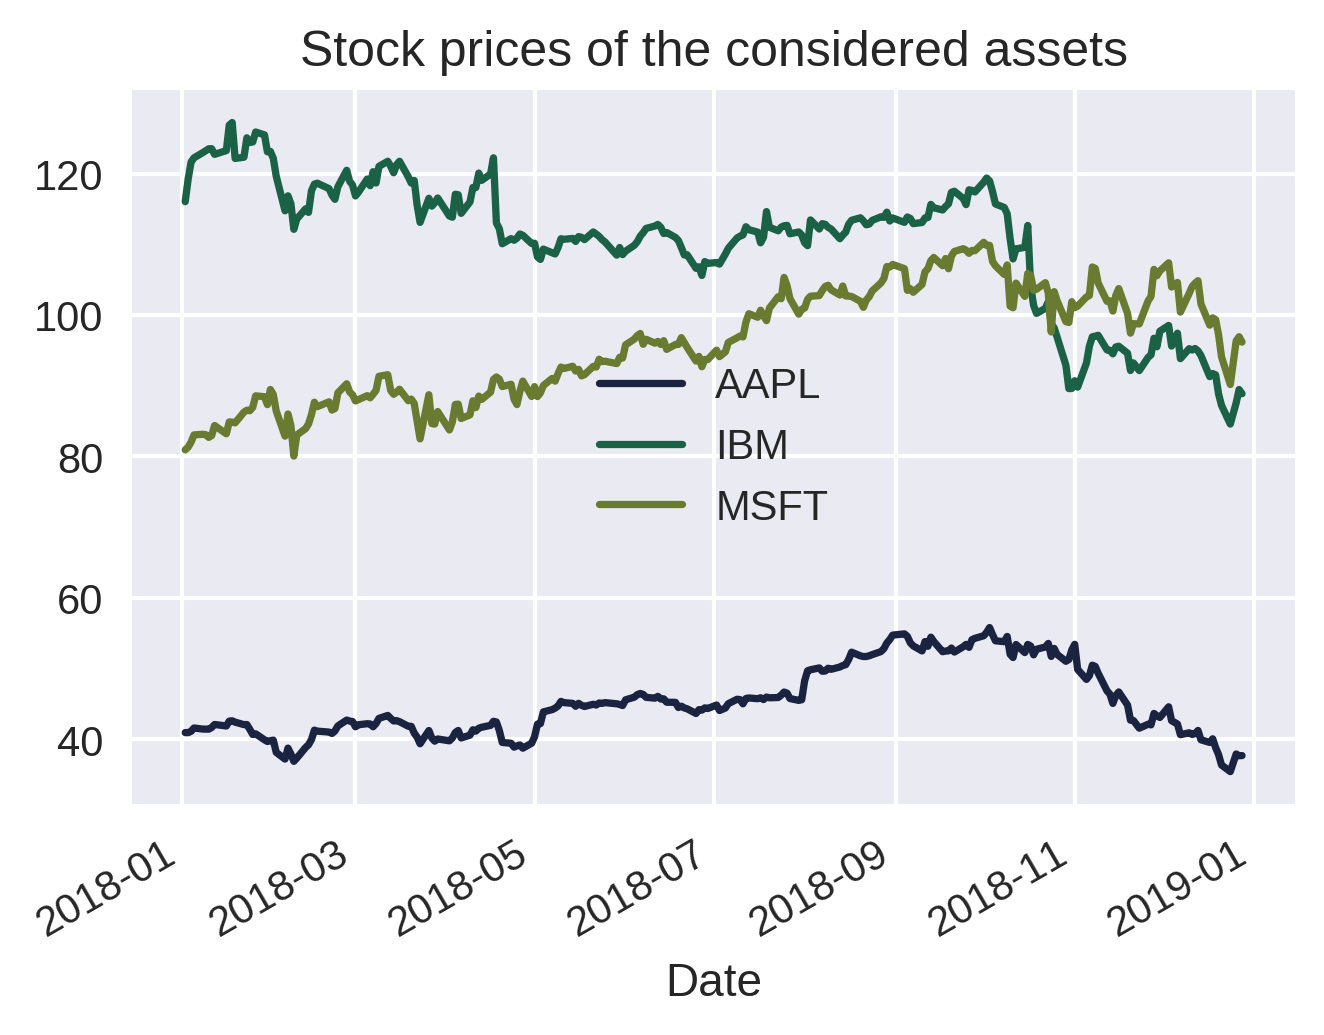

In [5]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

In [6]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * prices_df.shape[0]
cov_mat = returns_df.cov() * prices_df.shape[0]

In [7]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:,np.newaxis]

In [8]:
portf_rtns = np.dot(weights,avg_returns)

portf_vol = []
for i in range(0, len(weights)): 
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))

portf_vol = np.array(portf_vol) 
portf_sharpe_ratio = portf_rtns / portf_vol 

In [9]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol, 
                                 'sharpe_ratio': portf_sharpe_ratio})

In [10]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)

portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS): 
    if portf_rtns_ef[point_index] not in portf_rtns: 
         indices_to_skip.append(point_index) 
         continue 
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index]) 
    # return elements chosen from x or y depending on condition
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

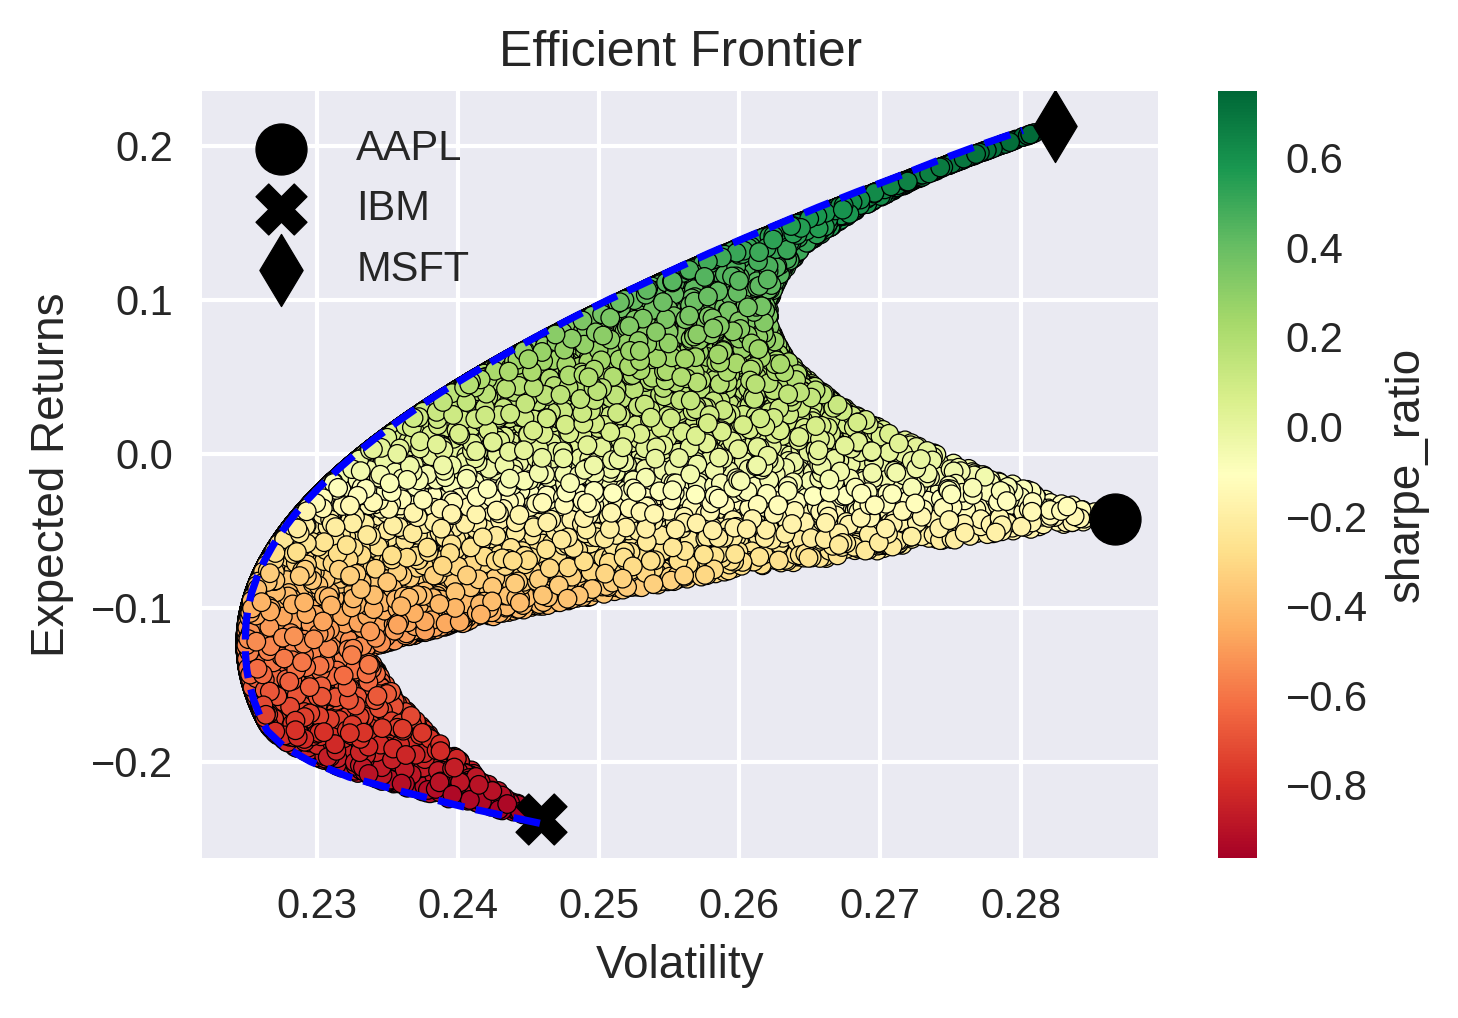

In [11]:
MARKS = ['o', 'X', 'd']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

In [12]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

HW3 (1)

In [13]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.11% volatility: 28.19% sharpe_ratio: 74.90% 
Weights
AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

HW3 (2)

In [14]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -12.29% volatility: 22.49% sharpe_ratio: -54.63% 
Weights
AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

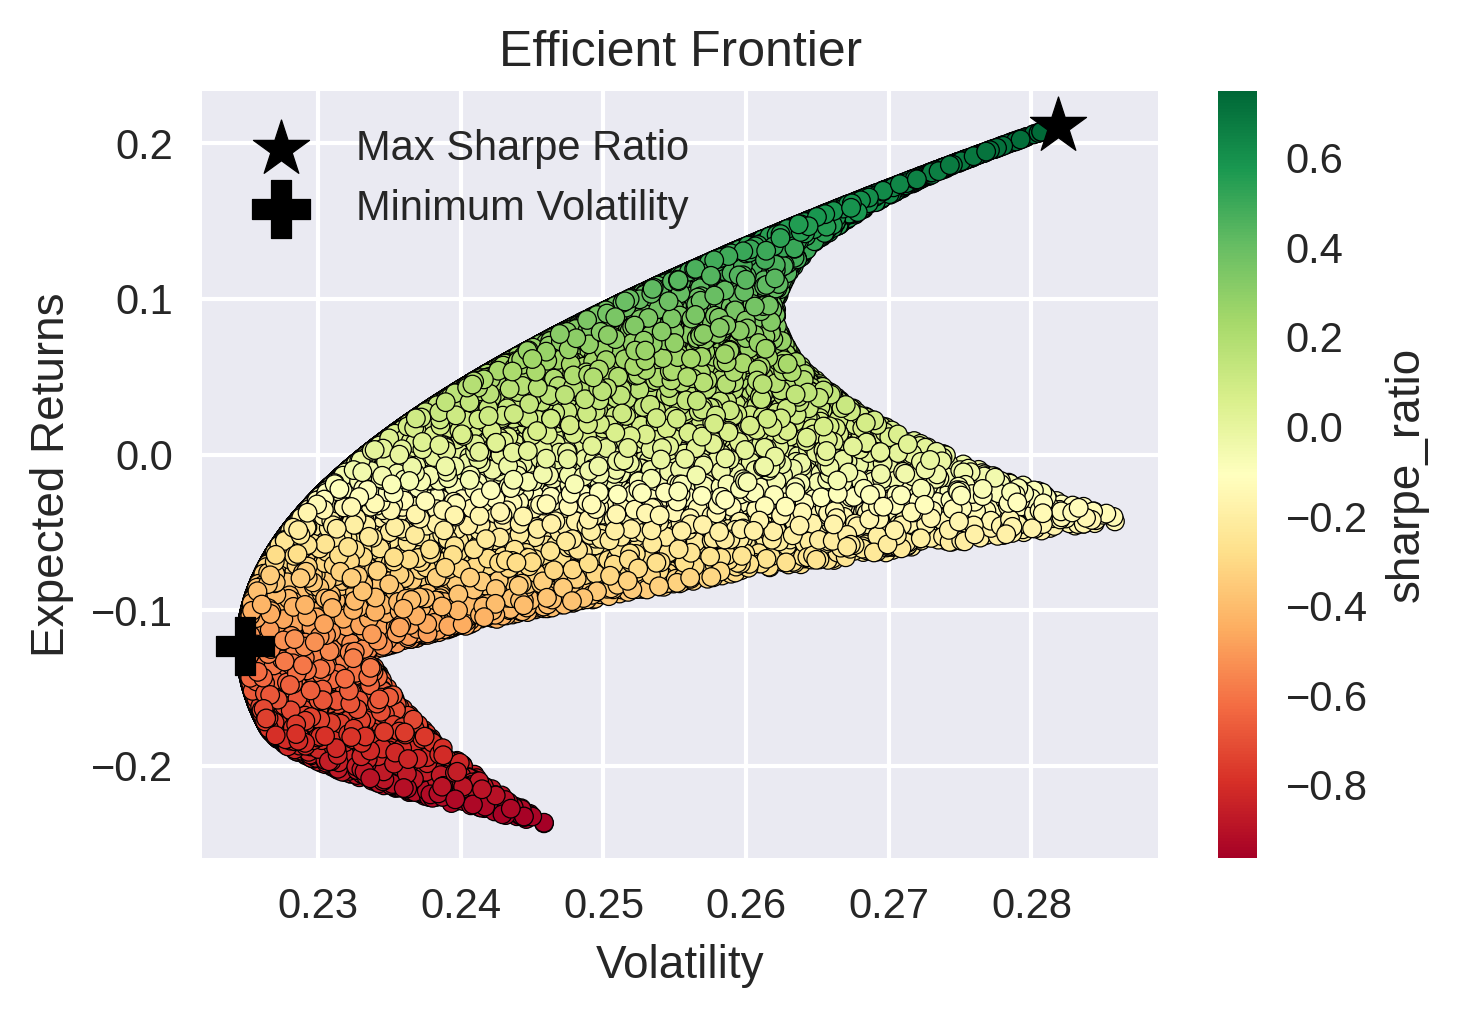

In [15]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()

#HW4

In [16]:
# Maximum Sharpe Ratio Monte Carlo

mu, vol = max_sharpe_portf.returns, max_sharpe_portf.volatility

max_sharpe_weights = weights[np.argmax(portf_results_df.sharpe_ratio)]
min_vol_weights = weights[np.argmin(portf_results_df.volatility)]

max_sharpe_rtn = (returns_df * max_sharpe_weights).sum(axis=1)
min_vol_rtn = (returns_df * min_vol_weights).sum(axis=1)

returns_df['max_sharpe'] = max_sharpe_rtn + 1
returns_df['min_vol'] = min_vol_rtn + 1

max_sharpe_list = [1]
for i in range(len(returns_df)):
  max_sharpe_list.append(max_sharpe_list[-1]*returns_df['max_sharpe'][i])

min_vol_list = [1]
for i in range(len(returns_df)):
  min_vol_list.append(min_vol_list[-1]*returns_df['min_vol'][i])

In [17]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):

    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [18]:
mu = max_sharpe_rtn.mean()
sigma = max_sharpe_rtn.std()
n_sims = 50
T = len(prices_df)-1
N = len(prices_df)-1
s_0 = 1

max_sharpe_gbm_simulations = simulate_gbm(s_0, mu, sigma, n_sims, T, N)

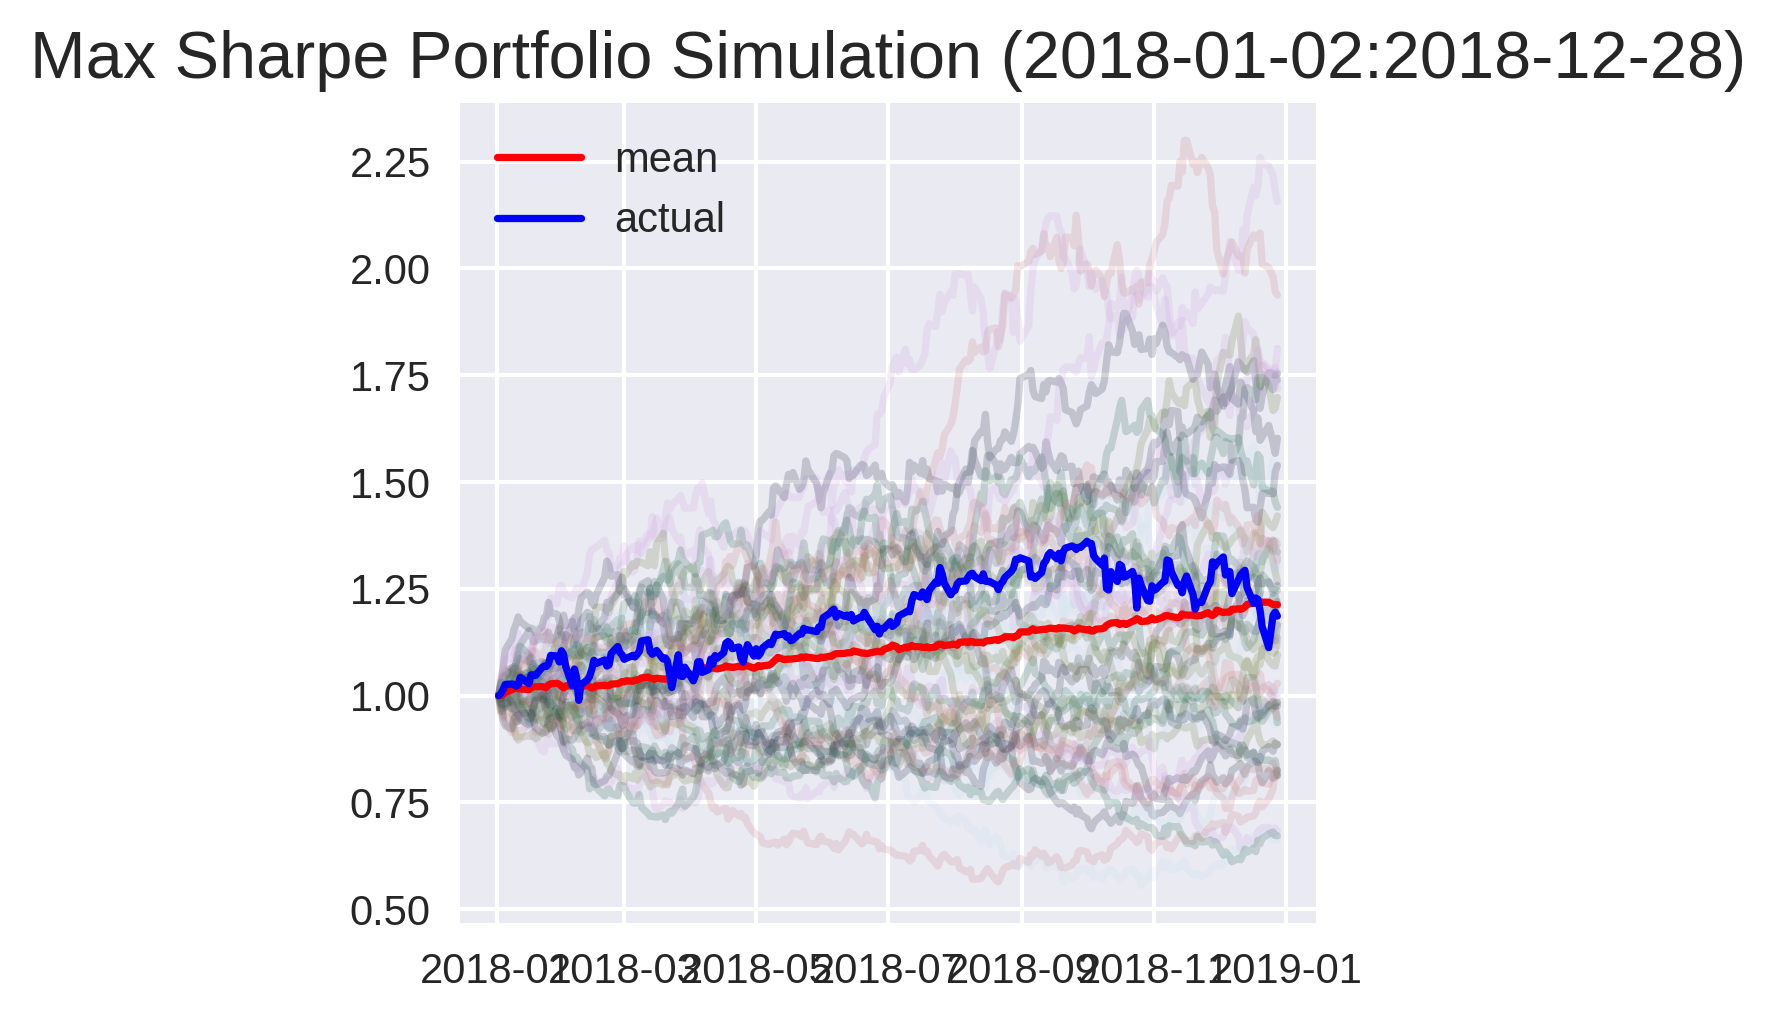

In [19]:
first_test_date = prices_df.index[0].date()
last_test_date = prices_df.index[-1].date()
plot_title = (f'Max Sharpe Portfolio Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = prices_df[first_test_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(max_sharpe_gbm_simulations), 
                                  index=index)

ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, max_sharpe_list, 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()

Min Vol Portfolio

In [20]:
mu = min_vol_rtn.mean()
sigma = min_vol_rtn.std()
n_sims = 50
T = len(prices_df)-1
N = len(prices_df)-1
s_0 = 1

In [21]:
min_vol_gbm_simulations = simulate_gbm(s_0, mu, sigma, n_sims, T, N)

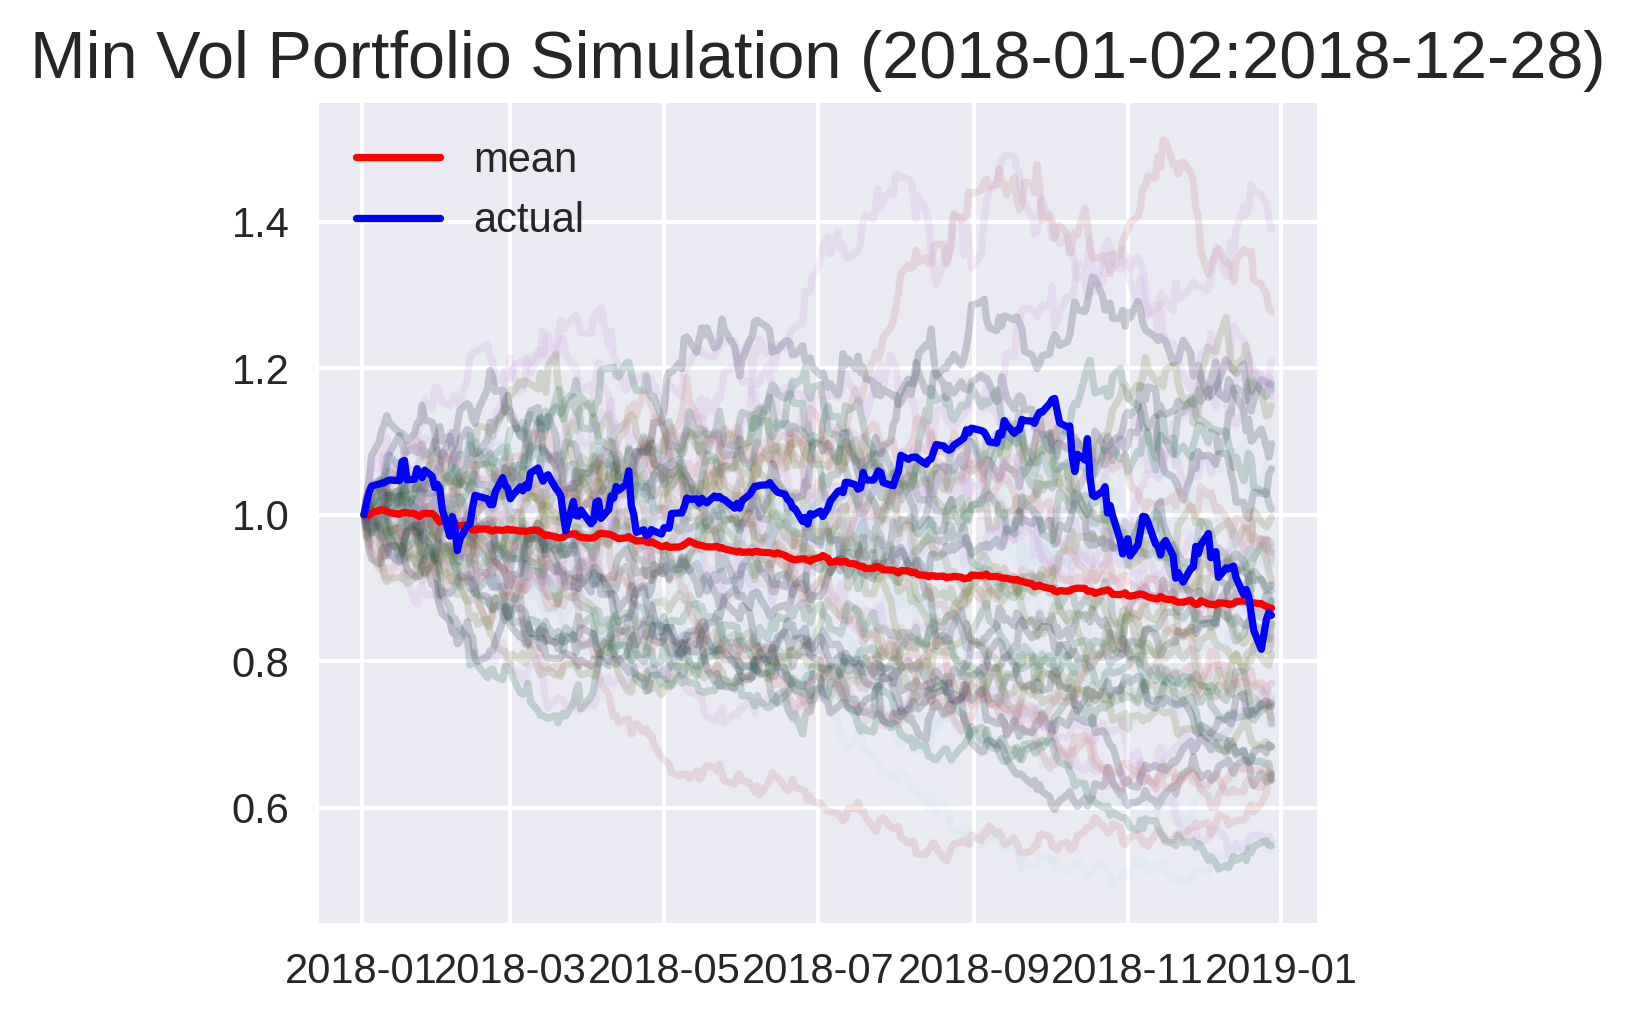

In [22]:
first_test_date = prices_df.index[0].date()
last_test_date = prices_df.index[-1].date()
plot_title = (f'Min Vol Portfolio Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = prices_df[first_test_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(min_vol_gbm_simulations), 
                                  index=index)

ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, min_vol_list, 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()